# Classification Predict - Climate Change

### Table of contents

### Problem identification

In [ ]:
# background and problem statement 

### What data do we have?

In [ ]:
# description of data

### Start experiment

##### Install necessary packages

In [ ]:
# Install necessary packages
# !pip install comet_ml

In [5]:
!pip install -U spacy

In [3]:
!pip install seaborn

In [4]:
!pip install wordcloud

In [ ]:
# from comet_ml import Experiment

In [ ]:
# Setting the API key (saved as environment variable)
# experiment = Experiment(api_key="upOwchWrd7H1e6VEnWKW7PSvz", project_name="classification-predict", workspace="team-rm1")

### Import libraries

In [2]:
import string
import re
from nltk import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix

from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score


import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from nltk.probability import FreqDist
from sklearn.utils import resample

#NLP basics
# Import spaCy and load the language library for tokenisation
import spacy
#Visualisations
from spacy import displacy
# Import the toolkit and the full Porter Stemmer library
import nltk
from nltk.stem.porter import *
#Snowball Stemmer
from nltk.stem.snowball import SnowballStemmer
# Import the Matcher library
from spacy.matcher import Matcher
# Import the PhraseMatcher library
from spacy.matcher import PhraseMatcher

#Parts of speech tagging
# Import the displaCy library for visualising POS
from spacy import displacy
#For adding what is not in a span to a Span (??will check it out)
from spacy.tokens import Span
#For sentence segmentation
from spacy.pipeline import SentenceSegmenter

#Text classification
#Import CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer
#Import TfidfTransformer
from sklearn.feature_extraction.text import TfidfTransformer
#Import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
#Import SVM classifier LinearSVC
from sklearn.svm import LinearSVC
#Setting up a pipeline
from sklearn.pipeline import Pipeline
# For reporting the confusion matrix
from sklearn import metrics
#Taking a look at a review
from IPython.display import Markdown, display
#Part of bulding pipeline
from sklearn.naive_bayes import MultinomialNB

#Sematics and sentiment analysis
from nltk.sentiment.vader import SentimentIntensityAnalyzer
#For reporting accuracy
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix

### Import data

In [3]:
df_test = pd.read_csv('https://raw.githubusercontent.com/Amogelang20/RM1_classification_predict/dev/test.csv')
df_train = pd.read_csv('https://raw.githubusercontent.com/Amogelang20/RM1_classification_predict/dev/train.csv')

In [4]:
df_train.set_index('tweetid',inplace = True)
df_train.head()

,sentiment,message
tweetid,,
625221,1,PolySciMajor EPA chief doesn't think carbon di...
126103,1,It's not like we lack evidence of anthropogeni...
698562,2,RT @RawStory: Researchers say we have three ye...
573736,1,#TodayinMaker# WIRED : 2016 was a pivotal year...
466954,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ..."


In [5]:
df_test.set_index('tweetid',inplace = True)
df_test.head()

,message
tweetid,
169760,Europe will now be looking to China to make su...
35326,Combine this with the polling of staffers re c...
224985,"The scary, unimpeachable evidence that climate..."
476263,@Karoli @morgfair @OsborneInk @dailykos \r\nPu...
872928,RT @FakeWillMoore: 'Female orgasms cause globa...


### Exploratory data analysis

In [6]:
# look at the type of data that is present. 
# look at the types and number of columns present. 
# look at the y variable, the number of classes it has. 
# check for imbalance of data in the different classes of y variable. 
# check for missing values.
# visualise the data.


In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15819 entries, 625221 to 806319
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  15819 non-null  int64 
 1   message    15819 non-null  object
dtypes: int64(1), object(1)
memory usage: 370.8+ KB


There are only two columns present in the training dataset. The label variable we want to classify to (`'sentiment'`) and the feature we will use to make this classification (`'message'`). We initially had a third column (`'tweetid'`) but set this column to be the index of the dataset.  

Next we'll have a look at the different labels we will be classifying to.

In [8]:
df_train['sentiment'].unique()

array([ 1,  2,  0, -1], dtype=int64)

The label has four different classes, described further in the following table:  

|Class|Tag|Description|  
|:---:|:---:|:---|  
|**-1**|**News**|The tweet links to factual news about climate change|  
|**0**|**Pro**|The tweet supports the belief of man-made climate change|   
|**1**|**Neutral**|The tweet neither supports nor refuses the belief of man-made climate change|   
|**2**|**Anti**|The tweet does not believe in man-made climate change|  

Let's have a look at the data associated with each class.

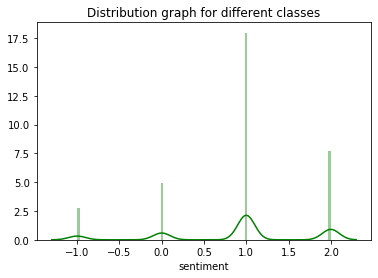

In [9]:
sns.distplot(df_train['sentiment'],
             color='g',kde_kws={'bw':0.1}, bins=100, hist_kws={'alpha': 0.4})
plt.title('Distribution graph for different classes');

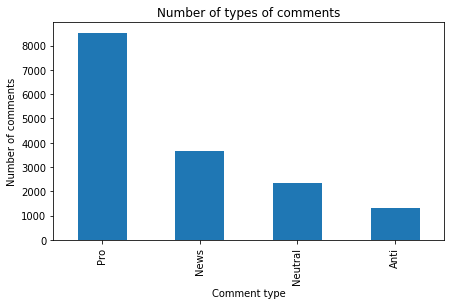

In [10]:
df_train['sentiment'].replace({-1: 'Anti',0:'Neutral',1:'Pro',2:'News'}).value_counts().plot(kind='bar',figsize=(7,4));
plt.title('Number of types of comments');
plt.xlabel('Comment type');
plt.ylabel('Number of comments');

Examining the plot reveals that the majority of the tweets are classified as neutral, i.e. neither supports nor refuses the belief of man-made climate change. Since the classes are so unbalanced we expect the classification algorithm to perform better when classifying larger classes ( _Neutral_ ) than the smaller classes ( _News, Pro, Anti_ ).  

Let's have a look at the most common words associated with each class.

In [11]:
df_Pro = df_train[df_train.sentiment==1]
df_News=df_train[df_train.sentiment==2]
df_Neutral=df_train[df_train.sentiment==0]
df_Anti=df_train[df_train.sentiment==-1]

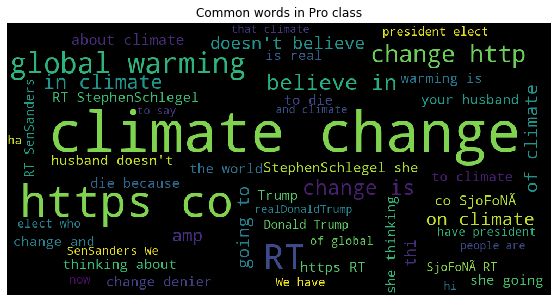

In [12]:
k= (' '.join(df_Pro['message']))

wordcloud = WordCloud(width = 1000, height = 500,max_words=50).generate(k)
plt.figure(figsize=(15,5))
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Common words in Pro class');

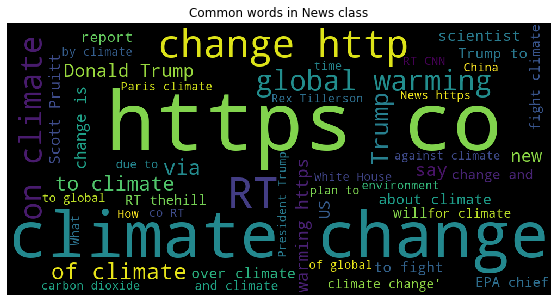

In [13]:
l= (' '.join(df_News['message']))

wordcloud = WordCloud(width = 1000, height = 500,max_words=50).generate(l)
plt.figure(figsize=(15,5))
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Common words in News class');

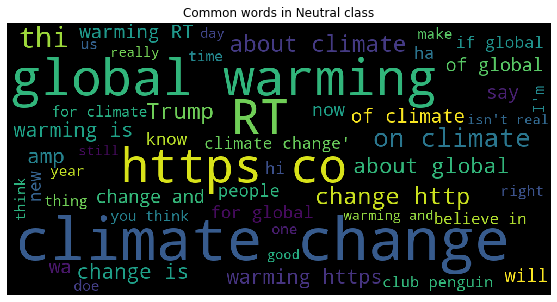

In [14]:
m= (' '.join(df_Neutral['message']))

wordcloud = WordCloud(width = 1000, height = 500,max_words=50).generate(m)
plt.figure(figsize=(15,5))
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Common words in Neutral class');

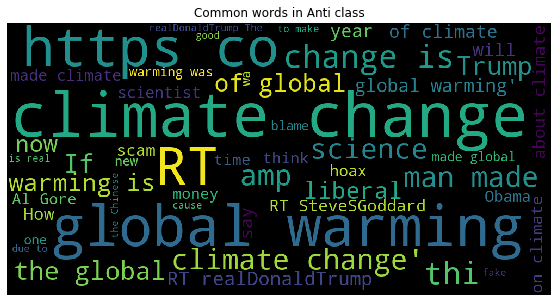

In [15]:
n= (' '.join(df_Anti['message']))

wordcloud = WordCloud(width = 1000, height = 500,max_words=50).generate(n)
plt.figure(figsize=(15,5))
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Common words in Anti class');

In [38]:
df_Pro_downsampled = resample(df_Pro,
                          replace=False, # sample without replacement (no need to duplicate observations)
                          n_samples=len(df_News), # match number in minority class
                          random_state=50) # reproducible results
downsampled = pd.concat([df_Pro_downsampled, df_News, df_Neutral, df_Anti])
downsampled['sentiment'].value_counts()

 2    3640
 1    3640
 0    2353
-1    1296
Name: sentiment, dtype: int64

In [30]:
downsampled = pd.concat([df_Pro_downsampled, df_News, df_Neutral, df_Anti])

In [25]:
downsampled

,sentiment,message
tweetid,,
98572,1,RT @jimsciutto: We are in a parallel universe ...
77569,1,Our inaction on climate change will be the bla...
399472,1,RT @LibyaLiberty: This was an eye opener - how...
177571,1,@IvankaTrump - so much for making climate chan...
698562,2,RT @RawStory: Researchers say we have three ye...
...,...,...
890582,-1,RT @dbongino: We're at the point w/the delusio...
380307,-1,RT @joshdcaplan: Al Gore admits Paris Accord w...
390339,-1,RT @JoshNoneYaBiz: Funny the same people who b...


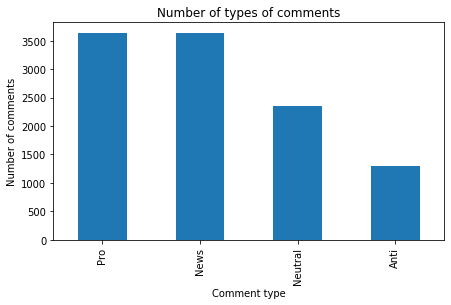

In [39]:
downsampled['sentiment'].replace({-1: 'Anti',0:'Neutral',1:'Pro',2:'News'}).value_counts().plot(kind='bar',figsize=(7,4));
plt.title('Number of types of comments');
plt.xlabel('Comment type');
plt.ylabel('Number of comments');

### Preprocessing

In [ ]:
#### CLEANING ####
# handle some of the unnecessary punctuation 
# upper/lower case
# change the slang words into something more meaningful to machine learning
# handle missing data and empty strings
# ect.


**Missing values**

In [ ]:
print(df_train.isnull().mean())

There are no missing values present in the training set. But since an empty string for tweets can also be considered missing, we need to check for empty strings in the `message` column as well.

In [ ]:
# Add indices of whitespace strings to a list
blank = [i for i,x in enumerate(df_train['message']) if type(x)==str and x.isspace()]

len(blank)

The list has a length of **0**, indicating that there are no empty strings as well.

In [ ]:
# Dictionary of contracted words
appos = {
"aren't" : "are not",
"can't" : "cannot",
"couldn't" : "could not",
"didn't" : "did not",
"doesn't" : "does not",
"don't" : "do not",
"hadn't" : "had not",
"hasn't" : "has not",
"haven't" : "have not",
"he'd" : "he would",
"he'll" : "he will",
"he's" : "he is",
"i'd" : "I would",
"i'd" : "I had",
"i'll" : "I will",
"i'm" : "I am",
"isn't" : "is not",
"it's" : "it is",
"it'll":"it will",
"i've" : "I have",
"let's" : "let us",
"mightn't" : "might not",
"mustn't" : "must not",
"shan't" : "shall not",
"she'd" : "she would",
"she'll" : "she will",
"she's" : "she is",
"shouldn't" : "should not",
"that's" : "that is",
"there's" : "there is",
"they'd" : "they would",
"they'll" : "they will",
"they're" : "they are",
"they've" : "they have",
"wasn't": "was not",
"we'd" : "we would",
"we're" : "we are",
"weren't" : "were not",
"we'll":"we will",
"we've" : "we have",
"what'll" : "what will",
"what're" : "what are",
"what's" : "what is",
"what've" : "what have",
"where's" : "where is",
"who'd" : "who would",
"who'll" : "who will",
"who's" : "who is",
"who've" : "who have",
"won't" : "will not",
"wouldn't" : "would not",
"you'd" : "you would",
"you'll" : "you will",
"you're" : "you are",
"you've" : "you have",
"'re": " are",
}

In [ ]:
# Change contracted words
df_train['message'] = [' '.join([appos[w.lower()] if w.lower() in appos.keys() else w for w in raw.split()]) for raw in df_train['message']]

In [10]:
# Extract all unique news related handles into a list
n_temp = [re.findall(r'@[\w]+',df_train['message'].iloc[i]) for i,x in enumerate(df_train['sentiment']) if x==2]
news = [x for x in n_temp if x!=[]]
news = list(set(itertools.chain.from_iterable(news)))

sentiment    0
message      0
dtype: int64

The data doesn't have any missing data so we don't have to drop any missing data

In [ ]:
#drop missing texts
# df_train.dropna(inplace = True)

In [15]:
 #dropping empty tweets
blanks = []  # start with an empty list
for i,lb,tweet in df_train.itertuples():  # iterate over the DataFrame
    if type(tweet)==str:            # avoid NaN values
        if tweet.isspace():         # test 'tweet' for whitespace
            blanks.append(i)     # add matching index numbers to the list
blanks
# df_train.drop(blanks, inplace=True)

[]

There are no empty strings so no dropping is essential here as well.

In [13]:
def data_cleaning(df):
    #substring

    #lower case all words to remove noise from Capital words. Capital words may be seen as different from lower case words
    df['message'] = df['message'].str.lower()
    
    df['message'] = df['message'].replace(r'&amp;', 'and', regex=True) #replace & with and
    df['message'] = df['message'].replace(r'https\S+','', regex=True).replace(r'www\S+', '', regex=True) #removing urls
    df['message'] = df['message'].str.replace('rt','') #replace 'rt' with retweet
    df['message'] = df['message'].str.replace('[^\w\s]','') #removing punctuations

    # remove duplicate tweets
    df_train.drop_duplicates(subset=['message'],keep = 'first',inplace = True)
    
    return df

In [ ]:
df_train = data_cleaning(df_train)

### Feature creation

In [ ]:
# Create some features from the given tweets,e.g length of tweet. Visualise these created features


### Split data into response and predictors

In [ ]:
#### clean_message = the cleaned text data ####
y = df_train['sentiment']
X = df_train['clean_message']

### Split data into training and validation sets

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Build pipelines to vectorize the data

In [ ]:
# Stem, tokenize and remove stopwords (all done within vectorization)
# Build a pipeline that vectorizes the text and creates classifiers for the different models 
# (logistic reg, SVM, Naive Bayes, Random Forest, Neural Nets)


In [ ]:
# Write class that has object that tokenizes text data AND stems the tokens
class StemAndTokenize:
    def __init__(self):
        self.ss = SnowballStemmer('english')
    def __call__(self, doc):
        return [self.ss.stem(t) for t in word_tokenize(doc)]

#### Logistic Regression

In [ ]:
# Create pipeline for Logistic Regression:
lr = Pipeline([('tfidf', TfidfVectorizer(tokenizer=StemAndTokenize())),
               ('lr', LogisticRegression())
              ])

#### Naïve Bayes

In [ ]:
# Create pipeline for Naïve Bayes:
nb = Pipeline([('tfidf', TfidfVectorizer(tokenizer=StemAndTokenize())),
               ('nb', MultinomialNB())
              ])

#### Linear SVM (Support Vector Machine)

In [ ]:
# Create pipeline for SVM:
Lsvm = Pipeline([('tfidf', TfidfVectorizer(tokenizer=StemAndTokenize())),
               ('Lsvm', LinearSVC())
              ])

#### Random Forest

In [ ]:
# Create pipeline for Random Forest:
rf = Pipeline([('tfidf', TfidfVectorizer(tokenizer=StemAndTokenize())),
               ('rf', RandomForestClassifier())
              ])

#### KNN (K Nearest Neighbors)

In [ ]:
# Create pipeline for KNN:
knn = Pipeline([('tfidf', TfidfVectorizer(tokenizer=StemAndTokenize())),
               ('knn', KNeighborsClassifier())
              ])

#### Neural Networks

In [ ]:
# Create pipeline for Neural Networks:
nn = Pipeline([('tfidf', TfidfVectorizer(tokenizer=StemAndTokenize())),
               ('nn', MLPClassifier())
              ])

### Hyperparameter optimization

In [ ]:
# optimize models by tuning parameters (GridSearch)


### Train models

#### Logistic Regression

In [ ]:
# Fitting the Logistic Regression model
lr.fit(X_train, y_train)

#### Naïve Bayes

In [ ]:
# Fitting the Naïve Bayes model
nb.fit(X_train, y_train)

#### Linear SVM (Support Vector Machine)

In [ ]:
# Fitting the SVM model
Lsvm.fit(X_train, y_train)

#### Random Forest

In [ ]:
# Fitting the Random Forest model
rf.fit(X_train, y_train)

#### KNN (K Nearest Neighbors)

In [ ]:
# Fitting the KNN model
knn.fit(X_train, y_train)

#### Neural Networks

In [ ]:
# Fitting the Neural Networks model
nn.fit(X_train, y_train)

### Make predictions

In [ ]:
# make predicts 


#### Logistic Regression

In [ ]:
# Form a prediction set for the Logistic Regression model
pred_lr = lr.predict(X_test)

#### Naïve Bayes

In [ ]:
# Form a prediction set for the Naïve Bayes model
pred_nb = nb.predict(X_test)

#### Linear SVM (Support Vector Machine)

In [ ]:
# Form a prediction set for the Linear SVM model
pred_Lsvm = Lsvm.predict(X_test)

#### Random Forest

In [ ]:
# Form a prediction set for the Random Forest model
pred_rf = rf.predict(X_test)

#### KNN (K Nearest Neighbors)

In [ ]:
# Form a prediction set for the KNN model
pred_knn = knn.predict(X_test)

#### Neural Networks

In [ ]:
# Form a prediction set for the Neural Network model
pred_nn = nn.predict(X_test)

### Evaluate model accuracy

In [ ]:
# confusion matrix
# classification report


#### Confusion Matrices

...

In [ ]:
labels = ['2: News', '1: Pro', '0: Neutral', '-1: Anti']

#### Logistic Regression

In [ ]:
pd.DataFrame(data=confusion_matrix(y_test, pred_lr), index=labels, columns=labels)

#### Naïve Bayes

In [ ]:
pd.DataFrame(data=confusion_matrix(y_test, pred_nb), index=labels, columns=labels)

#### Linear SVM (Support Vector Machine)

In [ ]:
pd.DataFrame(data=confusion_matrix(y_test, pred_Lsvm), index=labels, columns=labels)

#### Random Forest

In [ ]:
pd.DataFrame(data=confusion_matrix(y_test, pred_rf), index=labels, columns=labels)

#### KNN (K Nearest Neighbors)

In [ ]:
pd.DataFrame(data=confusion_matrix(y_test, pred_knn), index=labels, columns=labels)

#### Neural Networks

In [ ]:
pd.DataFrame(data=confusion_matrix(y_test, pred_nn), index=labels, columns=labels)

#### Classification Report

...

#### Logistic Regression

In [ ]:
print('Classification Report from Logistic Regression Model')
print(classification_report(y_test, pred_lr, target_names=['2: News', '1: Pro', '0: Neutral', '-1: Anti']))

#### Naïve Bayes

In [ ]:
print('Classification Report from Naïve Model')
print(classification_report(y_test, pred_nb, target_names=['2: News', '1: Pro', '0: Neutral', '-1: Anti']))

#### Linear SVM (Support Vector Machine)

In [ ]:
print('Classification Report from Linear SVM (Support Vector Machine) Model')
print(classification_report(y_test, pred_Lsvm, target_names=['2: News', '1: Pro', '0: Neutral', '-1: Anti']))

#### Random Forest

In [ ]:
print('Classification Report from Random Forest Model')
print(classification_report(y_test, pred_rf, target_names=['2: News', '1: Pro', '0: Neutral', '-1: Anti']))

#### KNN (K Nearest Neighbors)

In [ ]:
print('Classification Report from KNN(K Nearest Neighbours) Model')
print(classification_report(y_test, pred_knn, target_names=['2: News', '1: Pro', '0: Neutral', '-1: Anti']))

#### Neural Networks

In [ ]:
print('Classification Report from Neural Networks Model')
print(classification_report(y_test, pred_nn, target_names=['2: News', '1: Pro', '0: Neutral', '-1: Anti']))

In [ ]:
#Table for all models with only f1 score

In [ ]:
#lr.predict(X_test) -> use predictions created above
data = {'Model':['Logistic Regression','Naïve Bayes','Linear SVM','Random Forest','KNN','Neural Network'],
        'F1_score' :[f1_score(y_test, lr.predict(X_test)),
       f1_score(y_test, pred_lr),
       f1_score(y_test, pred_nb)
       f1_score(y_test, pred_Lsvm),
       f1_score(y_test, pred_knn),
       f1_score(y_test, pred_nn)]}

pd.DataFrame(data=data, columns=['Model F1_score'])

### Save the model

In [ ]:
# model = l_bm_1
# model_save_path = "model_sub3.pkl"
# with open(model_save_path,'wb') as file:
#     pickle.dump(model,file)

### Log parameters

In [ ]:
# save parameters in variables to be logged to comet


### End experiment

In [ ]:
# experiment.end()

### Conclusion